Tensor Field Networks

Implementation of moment of inertia demonstration

In [1]:
from math import pi, sqrt
import numpy as np
import torch
import random
import tensorfieldnetworks.layers as layers
import tensorfieldnetworks.utils as utils
from tensorfieldnetworks.utils import EPSILON, FLOAT_TYPE
xrange = range

/home/sebastian/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
num_points = 15

# radial basis functions
rbf_low = 0.
rbf_high = 2.
rbf_count = 30
rbf_spacing = (rbf_high - rbf_low) / rbf_count
centers = torch.Tensor(np.linspace(rbf_low, rbf_high, rbf_count))

In [3]:
def matrix_from_0_2(input_0, input_2):
    """
    inputs:
    -shape [N] tensor, L=0 feature at each point
    -shape [N, 5] tensor, L=2 feature vector at each point
    
    returns:
    -shape [N, 3, 3] tensor, matrix at each point
    """
    d_xy = input_2[:,0]
    d_yz = input_2[:,1]
    d_z2 = input_2[:,2]   # -x^2 - y^2 + 2*z^2
    d_zx = input_2[:,3]
    d_x2y2 = input_2[:,4] # x^2 - y^2
    Mxx = - d_z2 / sqrt(3.) + d_x2y2 + input_0
    Myy = - d_z2 / sqrt(3.) - d_x2y2 + input_0
    Mzz = 2*d_z2 / sqrt(3.) + input_0
    
    # rows : [N, 3]
    row0 = torch.stack([Mxx, d_xy, d_zx], dim=-1)
    row1 = torch.stack([d_xy, Myy, d_yz], dim=-1)
    row2 = torch.stack([d_zx, d_yz, Mzz], dim=-1)
    
    # [N, 3, 3]
    return torch.stack([row0, row1, row2], dim=-2)

In [4]:
def get_inputs(r):
    
    # rij : [N, N, 3]
    rij = utils.difference_matrix(r)

    # dij : [N, N]
    dij = utils.distance_matrix(r)

    # rbf : [N, N, rbf_count]
    gamma = 1. / rbf_spacing
    rbf = torch.exp(-gamma * (dij.unsqueeze(-1) - centers)**2)
    
    return rij, dij, rbf

In [5]:
class MOIModel(torch.nn.Module):
    
    def __init__(self, rbf_dimension):
        
        super().__init__()
        self.layer_0 = layers.Filter(0,0, rbf_dimension, nonlin=utils.ssp)
        self.layer_2 = layers.Filter(2,2, rbf_dimension, nonlin=utils.ssp)
    
    def forward(self, masses, rbf, rij):
        out_0 = self.layer_0(masses, rbf, rij).squeeze()
        out_2 = self.layer_2(masses, rbf, rij).squeeze()
        return matrix_from_0_2(out_0, out_2)
    

In [6]:
def random_points_and_masses(num_points=num_points, max_coord=rbf_high/4., min_mass=0.5, max_mass=2.0):
    """
    returns:
    -shape [num_points, 3] numpy array of points
    -shape [num_points] numpy array of masses
    """
    output_points = []
    for point in xrange(num_points):
        output_points.append(np.array([random.uniform(-max_coord, max_coord) for _ in range(3)]))
    
    points = np.array(output_points)
    masses = np.random.rand(len(output_points)) * (max_mass - min_mass) + min_mass
    return points, masses


def moi_tensor(points, masses, index):
    """
    inputs:
    -shape [N] tensor, L=0 feature at each point
    -shape [N, 5] tensor, L=2 feature vector at each point
    
    returns:
    -shape [N, 3, 3] tensor, matrix at each point
    """
    center = points[index]
    moi = np.full((3, 3), 0.)
    for point, mass in zip(points, masses):
        x, y, z = point - center
        Ixx = y**2 + z**2
        Iyy = x**2 + z**2
        Izz = x**2 + y**2
        Ixy = -x*y
        Iyz = -y*z
        Ixz = -x*z
        moi += np.array([[Ixx, Ixy, Ixz], 
                         [Ixy, Iyy, Iyz],
                         [Ixz, Iyz, Izz]]) * mass
    return moi

In [7]:
def R0_plot(model, x):
    gamma = 1. / rbf_spacing
    rbf_plot = np.exp(-gamma * (x - centers)**2)
    r_layer = model.layer_0.children().__next__().children().__next__()
    return r_layer(torch.Tensor(rbf_plot).unsqueeze(0))
    
def R2_plot(model, x):
    gamma = 1. / rbf_spacing
    rbf_plot = np.exp(-gamma * (x - centers)**2)
    r_layer = model.layer_2.children().__next__().children().__next__()
    return r_layer(torch.Tensor(rbf_plot).unsqueeze(0))


In [12]:
model = MOIModel(rbf_count)

In [13]:
import torch.optim as optim

criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
max_steps = 10001
print_freq = 1000
validation_size = 1000

x_vals = [index * rbf_high / rbf_count for index in xrange(rbf_count)]



# training
for step in xrange(max_steps):
    shape, rand_masses = random_points_and_masses()
    
    rand_masses = np.reshape(rand_masses, [-1, 1, 1])
    
    center_index = 0
    # make center point index have zero mass
    rand_masses[center_index] = 0.0

    truth = moi_tensor(shape, rand_masses, center_index)
    
    rand_masses = torch.Tensor(rand_masses)

    rij, dij, rbf = get_inputs(torch.Tensor(shape))

    optimizer.zero_grad()
    outputs = model(rand_masses.unsqueeze(0), rbf.unsqueeze(0), rij.unsqueeze(0))[ center_index]

    loss = criterion(outputs, torch.Tensor(truth))

    loss.backward()
    optimizer.step()
    
    if step % print_freq == 0:
        loss_sum = 0.
        for example in xrange(validation_size):
            shape, rand_masses = random_points_and_masses()
            rand_masses = np.reshape(rand_masses, [-1, 1, 1])
            rand_masses[center_index] = 0.0
            truth = moi_tensor(shape, rand_masses, center_index)
            rij, dij, rbf = get_inputs(torch.Tensor(shape))
            rand_masses = torch.Tensor(rand_masses)
           
            outputs = model(rand_masses.unsqueeze(0), rbf.unsqueeze(0), rij.unsqueeze(0))[center_index]
            loss = criterion(outputs, torch.Tensor(truth))
            
            loss_sum += loss.item()
        print("Step %d: validation loss = %.3f" % (step, loss_sum / validation_size))


        
    if step == max_steps - 1:
        y_vals = []
        for x_val in x_vals:
            y_vals.append(R0_plot(model,  x_val))
        F0_y_vals = y_vals
        
        y_vals = []
        for x_val in x_vals:
            y_vals.append(R2_plot(model,  x_val))
        F2_y_vals = y_vals

Step 0: validation loss = 11.978
Step 1000: validation loss = 0.006
Step 2000: validation loss = 0.006
Step 3000: validation loss = 0.000
Step 4000: validation loss = 0.006
Step 5000: validation loss = 0.004
Step 6000: validation loss = 0.056
Step 7000: validation loss = 0.000
Step 8000: validation loss = 0.004
Step 9000: validation loss = 0.001
Step 10000: validation loss = 0.003


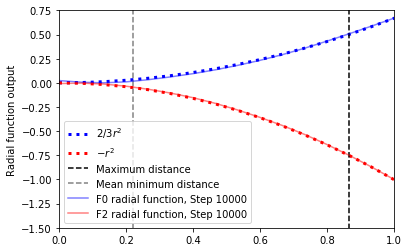

In [15]:
# plot radial functions vs analytic solution

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(1, sharex=True)

ax1.plot(x_vals, [2./3. * r_**2 for r_ in x_vals], "b:", lw=3, label="$2/3 r^2$")
ax1.plot(x_vals, [-r_**2 for r_ in x_vals], "r:", lw=3, label="$-r^2$")
ax1.plot([np.sqrt(3 * (rbf_high/4)**2), np.sqrt(3 * (rbf_high/4)**2)], [-4,4], '--', 
         color="#000000", label="Maximum distance")
ax1.plot([0.22, 0.22], [-4,4], '--', color="#818181", label="Mean minimum distance")

F0_y_vals_reshape = np.reshape(np.array(F0_y_vals), np.array(F0_y_vals).shape[0])
ax1.plot(x_vals, F0_y_vals_reshape, 'b-', label="F0 radial function, Step {}".format(step), alpha=0.5)

F2_y_vals_reshape = np.reshape(np.array(F2_y_vals), np.array(F2_y_vals).shape[0])
ax1.plot(x_vals, F2_y_vals_reshape,'r-', label="F2 radial function, Step {}".format(step), alpha=0.5)
    
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels)

ax1.set_xlim(0,1)
ax1.set_ylim(-1.5,0.75)
ax1.set_ylabel("Radial function output")
plt.show()